In this part I compared performance of svm and kNN on MNIST dataset.
Most of the code is from lab6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Next, fetch the digits with `fetch_mldata` command as shown in the demo.  Save the digits data matrix and labels to variables `Xdig` and `ydig`. 

In [2]:
from sklearn.datasets import fetch_mldata 
mnist = fetch_mldata('MNIST original')
Xdig  =  mnist.data
ydig = mnist.target
Xdigs = Xdig/255.0*2 - 1
Xdig[0,:].shape


(784,)

(784,)


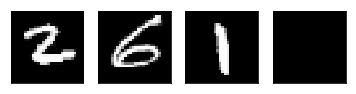

In [3]:
# TODO: Select four random digits and plot them using the subplot command
def plt_digit(x):
    nrow = 28
    ncol = 28
    xsq = x. reshape ((nrow, ncol)) 
    plt.imshow(xsq,   cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])



#Select random digits
nplt  = 4
nsamp = Xdigs.shape[0]
Iperm = np.random.permutation(nsamp)

#Plot the images using  the subplot  co   and
for i in range (nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1) 
    plt_digit(Xdigs [ind,:])

pic = np.zeros((784,))
print(pic.shape)
plt_digit(pic)

In the routines we will develop below, we will need to handle error conditions, called exceptions. A very nice description of how to perform exception handling in python is given in

In [4]:
class ImgException(Exception):
    def __init__(self, msg='No msg'):
        self.msg = msg

## Get Non-Digit Characters

We will now build a set of non-digit characters.  As a simple source, we will get hand-written lowercase letters 'a' to 'z' and process them with the `skimage` package.  The `skimage` module is a very powerful package that has a similar interface as OpenCV.  We first import the relevant modules.
We can get a set of character images from a very nice website
http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

Alternatively

https://drive.google.com/file/d/0BxOz-SM9a1h4UksxSXBjQ0dabUk/view?usp=sharing

In [5]:
import matplotlib.image as mpimg
import skimage.io
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.transform import resize
import matplotlib.patches as mpatches
from skimage import data
import skimage

In [6]:
import os.path

def load_img(char_ind, samp_ind):
    """
    Returns the image from the dataset given a character and sample index.
    
        
    If the file doesn't exist, it raises an Exception with the filename.   
    """ 
    
    # TODO:  Set the file name based on char_ind and samp_ind
    # fname = ...
    if (samp_ind < 10):
        fname='Sample0'+str(char_ind)+'/'+'img0'+str(char_ind)+'-00'+str(samp_ind)+'.png'
    else:
        fname='Sample0'+str(char_ind)+'/'+'img0'+str(char_ind)+'-0'+str(samp_ind)+'.png'
    # TODO:  Use the os.path.isfile command to check if the file exists.  
    # If not raise an ImgException with the message "[fname] not found"
    # 'C:\\Users\\kang\\Desktop\\introml-master\\svm\\img\\'
    # 'C:/Users/kang/Desktop/introml-master/svm/img/'

#     if os.path.isfile('C:/Users/kang/Desktop/introml-master/svm/img/'+fname):
#         img=skimage.io.imread('C:/Users/kang/Desktop/introml-master/svm/img/'+ fname) 
#     else:
#         raise ImgException(fname+" is not found")
    if os.path.isfile('C:/Users/Administrator/Desktop/introml-master/svm/img/'+fname):
        img=skimage.io.imread('C:/Users/Administrator/Desktop/introml-master/svm/img/'+ fname) 
    else:
        raise ImgException(fname+" is not found")

    # TODO:  Use the skimage.io.imread() command to read the png file and return the image.
    # img = ...
    return img



Test the `load_img` function.  This should:
* Plot the image in `Sample047\img047-006.png`
* Say that the `Sample047\img047-070.png` is not found.

Char = 47 samp=6
Sample047/img047-070.png is not found


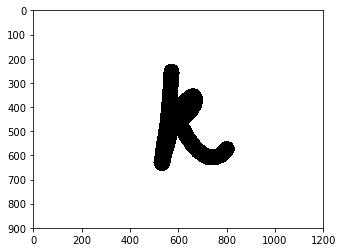

In [7]:
char_ind = 47
samp_inds = [6,70]
for samp_ind in samp_inds:
    try:
        img = load_img(char_ind=char_ind, samp_ind=samp_ind)
        print("Char = %d samp=%d" % (char_ind, samp_ind))
        plt.imshow(img)
    except ImgException as e:
        print(e.msg)

The images in the sample directory have very high resolution.  Complete the following method to find the image and place it in a 28 x 28 box.  You can look at this very nice demo of the `skimage` methods here:

http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

The code is somewhat complex, so I have provided some of the steps, esp. for the thresholding.

In [8]:
def mnist_resize(img):
    """
    Extracts a character from the image, and places in a 28x28 image to match the MNIST format.
    
    Returns:
    img1:  MNIST formatted 28 x 28 size image with the character from img
    box:   A bounding box indicating the locations where the character was found in img.    
    """
    # Image sizes (fixed for now).  To match the MNIST data, the image 
    # will be first resized to 20 x 20.  Then, the image will be placed in center of 28 x 28 box
    # offet by 4 on each side.
    nx_img = 20   
    ny_img = 20
    nx_box = 28   
    ny_box = 28
    offx = 4
    offy = 4
    
    # TODO:  Convert the image to gray scale using the skimage.color.rgb2gray method.
    # bw = ...
    bw = skimage.color.rgb2gray(img)
    # Threshold the image using OTSU threshold
    thresh = threshold_otsu(bw)
    bw = closing(bw < thresh, square(3)).astype(int)
    
    # Get the regions in the image.
    # This creates a list of regions in the image where the digit possibly is.
    regions = regionprops(bw)

    # TODO:  Find region with the largest area.  You can get the region area from region.area.
    # region_max = ...
    area_max = 0
    area_ind = 0
    for ind,reg in enumerate(regions):
        if(reg.area>area_max):
            area_ind = ind
            area_max = reg.area
    region_max = regions[area_ind]
    
    # Raise an ImgException if no region with area >= 100 was found
    if (area_max < 100):
        raise ImgException("No image found")    
                
    # Get the bounding box of the character from region_max.bbox
    minr, minc, maxr, maxc = region_max.bbox
    box = [minr,minc,maxr,maxc]
    
    # TODO:  Crop the image in bw to the bounding box
    # bw_crop = bw[...]
    bw_crop = bw[minr:maxr,minc:maxc]
    
    # TODO:  Resize the cropped image to a 20x20 using the resize command.
    # You will need to use the mode = 'constant' option
    # bw_resize = ...
    bw_resize = resize(bw_crop,(20,20),mode='constant')
    # TODO:  Threshold back to a 0-1 image by comparing the pixels to their mean value
    thresh = bw_resize.mean()
    for line in bw_resize:
        for i in range(len(line)):
            if line[i]< thresh:
                line[i] = 0
            else:
                line[i] = 1
    # TODO:  Place extracted 20 x 20 image in larger image 28 x 28
    # img1 = ...
    img1 = np.zeros([28,28])
    img1[offx:offx+nx_img,offy:offy+ny_img] = bw_resize
    return img1, box

Now, run the command `nlet=1000` times to get 1000 letter images.  In each iteration, select a random image from a lowercase letter and add it to a matrix `Xlet`. 

In [9]:
# Dimensions
nlet = 1000
nrow = 28
ncol = 28
npix = nrow*ncol
Xlet = np.zeros((nlet, npix))
from random import randint

i = 0
while i < nlet:
    # TODO:  Generate a random character and sample    
    # char_ind = random number corresponding to a lowercase letter except 'O' and 'I'
    # samp_ind = random number from 0 to 49
    while():
        char_ind = randint(37,63)
        if(char_ind!=45 and char_ind!=51):
            break
    samp_ind = randint(0,50)
    try:
        # TODO:  Load the image with load_img function
        # img = ...
        img = load_img(char_ind,samp_ind)
        # TODO:  Reize the image with mnist_resize function
        # img1, box = ...
        img1,box = mnist_resize(img)
        # TODO:  Store the image in a row of Xlet[i,:] and increment i
        Xlet[i,:] = img1.ravel()
        i += 1
        
        # Print progress
        if (i % 50 == 0):
            print ('images captured = {0:d}'.format(i))
    except ImgException:
        # Skip if image loading or resizing failed
        pass

images captured = 50
images captured = 100
images captured = 150
images captured = 200
images captured = 250
images captured = 300
images captured = 350
images captured = 400
images captured = 450
images captured = 500
images captured = 550
images captured = 600
images captured = 650
images captured = 700
images captured = 750
images captured = 800
images captured = 850
images captured = 900
images captured = 950
images captured = 1000


Since this takes a long time to generate, save the matrix `Xlet` to a file `Xlet.p` using the `pickle.dump` command.

In [10]:
import pickle

# TODO
with open('Xlet.p','wb') as f:
    pickle.dump(Xlet,f)
    

Reload the data `Xlet` from the file `Xlet.p`

In [11]:
# TODO
with open('Xlet.p','rb') as f:
    Xlet=pickle.load(f)

## Create Extended Training Data

Now, create an extended data set by combining `ndig=5000` randomly selected digit samples and `nlet=1000` letters. 
* Select `ndig=5000` random samples from `Xdigs` and their labels in `ydig`.
* Rescale the letters `Xlet` to a new matrix `Xlets = 2*Xlet-1` to make the pixel values go from -1 to 1.
* Use the `np.vstack` command to create a 6000 element alpha-numeric data set `X`
* Create a corresponding label vector `y` where all the non-digit characters are labeled with a non-digit label, `letter_lbl=10`.


In [12]:
# TODO
# X = ...  Array with 6000 characters (5000 digits + 1000 letters)
# y = ...  Array with 6000 labels (0-9 for the digits, 10 = non-digit)
ndig = 5000
ind = np.random.randint(70000,size=5000)
Xlets = 2*Xlet-1
Xsamp=np.zeros((5000,784))
ysamp=np.zeros(5000,)

for i in range(ndig):
    j = ind[i]
    Xsamp[i,:]=Xdigs[j,:]
    ysamp[i]=ydig[j]
X = np.vstack((Xsamp,Xlets))
ynond = np.ones((1000,))*10
y = np.concatenate((ysamp,ynond),axis=0)
y.shape

(6000,)

# Run the SVM classifier

First create the SVM classifer.  Use an "rbf" classifier with `C=2.8` and `gamma=.0073`.  Not sure if these are the best parameters, you could try to search for better ones.

In [13]:
from sklearn import svm

# TODO:  Create a classifier: a support vector classifier
# svc = ...
svc = svm.SVC(probability=False, kernel = 'rbf', C=2.8, gamma=.0073, verbose=10)

Get 5000 training samples `Xtr,ytr` and 1000 test samples `Xts,yts`.  Remember to randomly select them.

In [14]:
# TODO
# Xtr = ...
# ytr = ...
# Xts = ...
# yts = ...
index = np.random.permutation(6000)
ntr=5000
nts=1000
Xtr=X[index[:ntr],:]
ytr=y[index[:ntr]]
Xts=X[index[ntr:ntr+nts],:]
yts=y[index[ntr:ntr+nts]]

Use the `svc.fit` command to fit on the training data.  This may take a few minutes

In [15]:
# TODO
svc.fit(Xtr,ytr)

[LibSVM]

SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0073, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=10)

Measure the accuracy on the test samples.  You should get about 96% accuracy.  You can get better by using more training samples, but it will just take longer to run.

In [16]:
# TODO
yhat_ts = svc.predict(Xts)
acc = np.mean(yhat_ts == yts)
print('accuracy = {0:f}'.format(acc))

accuracy = 0.967000


use model kNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier
kNN = KNeighborsClassifier()
kNN.fit(Xtr,ytr)

yhat_ts1 = kNN.predict(Xts)
acc = np.mean(yhat_ts1 == yts)
print('accuracy = {0:f}'.format(acc))

accuracy = 0.941000
